In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/팀우이홍황')

Mounted at /content/drive


     |████████████████████████████████| 231 kB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 8.6 MB/s  eta 0:00:01


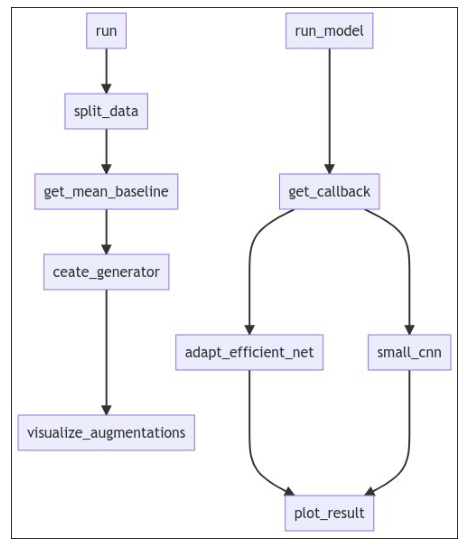

In [2]:
#@title
# https://github.com/pleabargain/ipynb/blob/master/some_mermaid_diagrams_work_in_google_colab.ipynb
!pip install rich

import rich
import base64
import requests, io
from PIL import Image
import matplotlib.pyplot as plt

graph = """
  graph TD;
      run --> split_data;
      split_data-->get_mean_baseline;
      get_mean_baseline-->ceate_generator;
	  ceate_generator--->visualize_augmentations;
	  run_model ---> get_callback;
	  get_callback ---> adapt_efficient_net;
	  get_callback ---> small_cnn;
	  adapt_efficient_net ---> plot_result;
	  small_cnn ---> plot_result;
"""

graphbytes = graph.encode("ascii")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")
img = Image.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
plt.figure(figsize=(8, 12))
plt.imshow(img)
plt.xticks([])
_ = plt.yticks([])

## 예비 작업
꽤 많은 시간을 데이터 전처리에 할애합니다. 전체 코드는 [깃허브 저장소](https://github.com/MarkusRosen/keras-efficientnet-regression/blob/master/efficient_net_keras_regression.py)를 참고합니다.

In [3]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.0 MB/s eta 0:00:01


In [4]:
from typing import Iterator, List, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

import tensorflow_addons as tfa

### EfficientNetB0 체크포인트
이제 Noisy_Student 증강으로 학습된 EfficientNetB0 체크포인트를 다운로드하고 이를 전이학습에 사용하도록 변환시키도록 하겠습니다.
- 변환 코드는 공식 keras 문서를 참고로 작성되었습니다.

In [5]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!tar -xf noisy_student_efficientnet-b0.tar.gz
%ls

--2022-05-19 02:09:22--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156407520 (149M) [application/octet-stream]
Saving to: ‘noisy_student_efficientnet-b0.tar.gz.1’

noisy_student_effic 100%[===================>] 149.16M  28.8MB/s    in 5.2s    

2022-05-19 02:09:27 (28.8 MB/s) - ‘noisy_student_efficientnet-b0.tar.gz.1’ saved [156407520/156407520]

'참고 수업자료'/                        noisy_student_efficientnet-b0.tar.gz.1
'0. 최종발표 ppt.gslides'               osk_EDA.ipynb
'1조 평가표.hwp'                       'osk_EDA.ipynb의 사본'
'이상치처리1(LED).ipynb'               'osk_EDA.ipynb의 사본2'
 avg_train.csv                          outlie

이제 학습에 필요한 EfficientNet b0 학습 파라미터 변환코드를 다운로드하고 변환작업을 실행 하겠습니다.

In [6]:
!wget https://raw.githubusercontent.com/MarkusRosen/keras-efficientnet-regression/master/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --notop --ckpt noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0_notop.h5
%ls

--2022-05-19 02:09:31--  https://raw.githubusercontent.com/MarkusRosen/keras-efficientnet-regression/master/efficientnet_weight_update_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13639 (13K) [text/plain]
Saving to: ‘efficientnet_weight_update_util.py.1’

efficientnet_weight 100%[===================>]  13.32K  --.-KB/s    in 0.002s  

2022-05-19 02:09:32 (5.59 MB/s) - ‘efficientnet_weight_update_util.py.1’ saved [13639/13639]

2022-05-19 02:09:40.375199: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
16719872/16705208 [==============================] - 1s 0us/step
check variables match in each block
blocks_

### 데이터 탐색
먼저 df.pkl 파일을 읽고, 우리의 폴더 구조에 맞게 image_location 컬럼을 생성하고 데이터프레임을 리턴하는 함수를 작성하겠습니다.


아래 임시 생성한 df는 여러 함수들을 테스트하는 용도로 재활용됩니다.

In [7]:
def run(small_sample=False):
    """Run all the code of this file.

    Parameters
    ----------
    small_sample : bool, optional
        If you just want to check if the code is working, set small_sample to True, by default False
    """

    df = pd.read_csv('./avg_train.csv')
    df = df.drop(columns = ['Unnamed: 0'])
    df = df[['image_location', '중량', '내부온도관측치', '외부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '난방부하']]

    if small_sample == True:
        df = df.iloc[0:1000]
    
    return df

df = run()
df.head()

,image_location,중량,내부온도관측치,외부온도관측치,내부습도관측치,CO2관측치,EC관측치,난방부하
0,./dataset/train/CASE01/image/CASE01_01.png,49.193,22.236181,43.868542,77.740695,487.226389,19.594792,10.227934
1,./dataset/train/CASE01/image/CASE01_02.png,59.764,22.931111,39.537708,77.514931,489.068750,20.748611,13.347289
2,./dataset/train/CASE01/image/CASE01_03.png,72.209,21.027986,58.497500,80.069930,481.378472,18.195278,7.522328
3,./dataset/train/CASE01/image/CASE01_04.png,85.737,23.011319,44.573750,77.645972,480.144444,20.855555,13.706011
4,./dataset/train/CASE01/image/CASE01_05.png,102.537,24.452467,56.567686,81.520709,512.528839,23.363377,20.794515


In [8]:
test = pd.read_csv('./total_test.csv')
test = test.drop(columns = ['Unnamed: 0'])
test = test[['image_location', '내부온도관측치', '외부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '난방부하']]

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_location  460 non-null    object 
 1   내부온도관측치         460 non-null    float64
 2   외부온도관측치         460 non-null    float64
 3   내부습도관측치         460 non-null    float64
 4   CO2관측치          460 non-null    float64
 5   EC관측치           460 non-null    float64
 6   난방부하            460 non-null    float64
dtypes: float64(6), object(1)
memory usage: 25.3+ KB


In [10]:
test_featurecols = test.columns.drop(['image_location'])
test_featurecols

Index(['내부온도관측치', '외부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '난방부하'], dtype='object')

사용할 데이터의 특징을 보겠습니다.

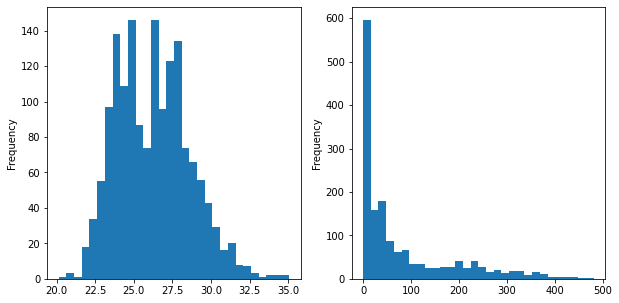

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for col, ax in zip(['내부온도관측치', '중량'], axes.flatten()):
    df[col].plot.hist(bins=30, ax = ax)

In [12]:
# means, stds = df[['price', 'area']].mean(0), df[['price', 'area']].std(0)
# means, stds

In [13]:
# df[['price', 'area']] = (df[['price', 'area']] - means)/stds

In [14]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# for col, ax in zip(['price', 'area'], axes.flatten()):
#     df[col].plot.hist(bins=30, ax = ax)

In [15]:
df = df.fillna(0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592 entries, 0 to 1591
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_location  1592 non-null   object 
 1   중량              1592 non-null   float64
 2   내부온도관측치         1592 non-null   float64
 3   외부온도관측치         1592 non-null   float64
 4   내부습도관측치         1592 non-null   float64
 5   CO2관측치          1592 non-null   float64
 6   EC관측치           1592 non-null   float64
 7   난방부하            1592 non-null   float64
dtypes: float64(7), object(1)
memory usage: 99.6+ KB


In [17]:
featurecols = df.columns.drop(['image_location'])
featurecols

Index(['중량', '내부온도관측치', '외부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '난방부하'], dtype='object')

### 데이터 전처리

#### 데이터 분할
우리의 데이터는 훈련, 검증 및 테스트 데이터 세트로 분할하고, 훈련 데이터의 평균값으로 단순 예측하는 기준값을 준비하겠습니다.

In [18]:
def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Accepts a Pandas DataFrame and splits it into training, testing and validation data. 
    Returns DataFrames.

    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.

    Returns
    -------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        [description]
    """
    train, val = train_test_split(df, test_size=0.2, random_state=1)  # split the data with a validation size o 20%
    
    print("shape train: ", train.shape)  # type: ignore
    print("shape val: ", val.shape)  # type: ignore

    print("Descriptive statistics of train:")
    print(train.describe())  # type: ignore
    return train, val # type: ignore

In [19]:
train, val = split_data(df)

shape train:  (1273, 8)
shape val:  (319, 8)
Descriptive statistics of train:
                중량      내부온도관측치      외부온도관측치      내부습도관측치       CO2관측치  \
count  1273.000000  1273.000000  1273.000000  1273.000000  1273.000000   
mean     78.851169    26.235607    26.201403    63.105240   489.236860   
std     101.049931     2.356903     5.330607    12.889160    73.265640   
min       0.000000    20.131458    15.248292    29.294375   353.652536   
25%       5.839000    24.431389    23.029993    54.480833   444.369444   
50%      34.485000    26.272917    26.383125    59.402153   473.336345   
75%     113.544000    27.834051    28.291875    77.143472   515.549061   
max     481.375000    35.073125    74.012153    84.809666  1011.107019   

             EC관측치         난방부하  
count  1273.000000  1273.000000  
mean      1.613531     1.123798  
std       2.599613     4.765584  
min       0.000000     0.000000  
25%       0.437519     0.000000  
50%       1.588424     0.000000  
75%       1.82689

In [20]:
def get_mean_baseline(train: pd.DataFrame, val: pd.DataFrame) -> float:
    """Calculates the mean MAE and MAPE baselines by taking the mean values of the training data as prediction for the
    validation target feature.

    Parameters
    ----------
    train : pd.DataFrame
        Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Pandas DataFrame containing your validation data.

    Returns
    -------
    float
        MAPE value.
    """
    val = val.copy()
    y_hat = train["중량"].mean()
    val["y_hat"] = y_hat
    mae = MeanAbsoluteError()
    mae = mae(val["중량"], val["y_hat"]).numpy()  # type: ignore

    print("mean baseline MAE: ", mae)

    return mae

In [21]:
_ = get_mean_baseline(train, val)

mean baseline MAE:  84.88249206542969


In [22]:
val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 75 to 1317
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_location  319 non-null    object 
 1   중량              319 non-null    float64
 2   내부온도관측치         319 non-null    float64
 3   외부온도관측치         319 non-null    float64
 4   내부습도관측치         319 non-null    float64
 5   CO2관측치          319 non-null    float64
 6   EC관측치           319 non-null    float64
 7   난방부하            319 non-null    float64
dtypes: float64(7), object(1)
memory usage: 22.4+ KB


#### ImageDataGenerator 만들기
이제 입력 데이터를 받아 데이터 의 각 분할에 대해 하나씩 ImageDataGenerator를 생성하는 create_generators 함수를 작성합니다:
1. 몇가지 표준 증강을 수행하는 ImageDataGenerator 인스턴스를 생성하고
2. flow_from_dataframe 옵션으로 df로 부터 이미지를 batch 단위로 생성하는 생성자를 만듭니다.

In [23]:
BATCH_SIZE = 128
def create_generators(
    df: pd.DataFrame, train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame, viz_aug=False
) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts four Pandas DataFrames: all your data, the training, validation and test DataFrames. Creates and returns
    keras ImageDataGenerators. Within this function you can also visualize the augmentations of the ImageDataGenerators.

    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    train : pd.DataFrame
        Your Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Your Pandas DataFrame containing your validation data.
    test : pd.DataFrame
        Your Pandas DataFrame containing your testing data.

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, validating and testing of your models.
    """

    # create an ImageDataGenerator with multiple image augmentations
    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True
    )  
    # except for rescaling, no augmentations are needed for validation and testing generators
    validation_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)
    
    # visualize image augmentations
    if viz_aug:
        visualize_augmentations(train_generator, df)

    train_generator = train_generator.flow_from_dataframe(
        dataframe=train,
        x_col="image_location",  # this is where your image data is stored
        y_col=featurecols,  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(224, 224),
        batch_size=BATCH_SIZE, # increase or decrease to fit your GPU
    )

    validation_generator = validation_generator.flow_from_dataframe(
        dataframe=val,
        x_col="image_location",
        y_col=featurecols,
        class_mode="raw",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_generator = test_generator.flow_from_dataframe(
        dataframe=test,
        x_col="image_location",
        y_col=test_featurecols,
        class_mode="raw",
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

#### 데이터 증강 시각화
실제 응용 프로그램에서 의미가 있는지 확인하기 위해 데이터 증강을 조사해야 합니다.

위에서 정의한 함수에서 사용할 visualize_augmentations 함수를 작성하여 :
- 동일한 이미지 파일에 대해 9번의 증강을 연속해서 수행하고
- 3x3의 그리드에 증강 이미지를 시각화하겠습니다.

In [24]:
def visualize_augmentations(data_generator: ImageDataGenerator, df: pd.DataFrame):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid. This function is part of create_generators() and
    can be accessed from there.

    Parameters
    ----------
    data_generator : Iterator
        The keras data generator of your training data.
    df : pd.DataFrame
        The Pandas DataFrame containing your training data.
    """
    # super hacky way of creating a small dataframe with one image
    series = df.iloc[2]

    df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()

    iterator_visualizations = data_generator.flow_from_dataframe(  # type: ignore
        dataframe=df_augmentation_visualization,
        x_col="image_location",
        y_col="중량",
        class_mode="raw",
        target_size=(224, 224),  # size of the image
        batch_size=1,  # use only one image for visualization
    )

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
        batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
        img = batch[0][0]  # type: ignore
        plt.imshow(img)
    plt.show()
    plt.close()

Found 2 validated image filenames.


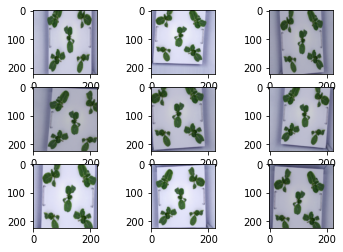

Found 1273 validated image filenames.
Found 319 validated image filenames.
Found 460 validated image filenames.


In [25]:
train_generator, validation_generator, test_generator = create_generators(df, train, val, test, True)

#### Custom Genearator
이제, 이미지 X1과 이미지 메타데이터 X2, 타겟 y를 분리하는 제너레이터를 생성합니다.

In [26]:
def own_train_generator_func():
    count = 0
    while True:
        if count >= len(train.index):
            train_generator.reset()
            count = 0
            #break
        count += BATCH_SIZE
        data = train_generator.next()
        
        imgs = data[0]
        meta = data[1][:,1:]
        targets = data[1][:,:1]
        
        yield [imgs, meta], targets

def own_val_generator_func():
    count = 0
    while True:
        if count >= len(val.index):
            validation_generator.reset()
            count = 0
            #break
        count += BATCH_SIZE
        data = validation_generator.next()
                
        imgs = data[0]
        meta = data[1][:,1:]
        targets = data[1][:,:1]
        
        yield [imgs, meta], targets

def own_test_generator_func():
    count = 0
    while True:
        if count >= len(test.index):
            test_generator.reset()
            count = 0
            #break
        count += BATCH_SIZE
        data = test_generator.next()
                
        imgs = data[0]
        meta = data[1]
        
        return imgs, meta

## 딥러닝 모델 생성
우리는 사전 훈련된 EfficientNet과 간단한 CNN 모델을 비교하고자 합니다. 이를 위해 :
1. 이미지 데이터를 입력으로 하는 작은 CNN 모듈과 EfficientNet 모듈을 생성하고
2. 이미지 메터 데이터에서 특징을 추출하는 메타 모듈을 생성하고,
3. 두 개의 모듈을 결합하여 최종 회귀 모델을 구성하는 combineModel을 정으하겠습니다.
4. 이를 통해 학습과정을 일반화할 수 있는 함수를 작성하고
5. 학습과정에 사용할 수 있는 콜백함수를 정의하겠습니다.

### CNN 모델 정의

#### 작은 CNN 모델 정의
EfficientNet과의 비교를 위해 작은 CNN 모델을 정의합니다.

In [27]:
def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.

    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential(name="SmallCNN")
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(64, activation="relu"))

    return model

In [28]:
small_cnn().summary()

Model: "SmallCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0  

#### Efficient 모델 정의

In [29]:
%ls

'참고 수업자료'/                        noisy_student_efficientnet-b0.tar.gz.1
'0. 최종발표 ppt.gslides'               osk_EDA.ipynb
'1조 평가표.hwp'                       'osk_EDA.ipynb의 사본'
'이상치처리1(LED).ipynb'               'osk_EDA.ipynb의 사본2'
 avg_train.csv                          outlier.ipynb
'[Baseline]_ResNet50 + LSTM.ipynb'      red_lettuce/
'[Baseline]_Simple CNN_hsh.ipynb'       resnet_rand_30ep.csv
'[Baseline]_Simple CNN.ipynb'           resnet_random_20ep.csv
'[Baseline]_Simple CNN.ipynb(woo)'      resnet_random.ipynb
'[Baseline]_Simple_resnet.ipynb'        saved/
 check_null.csv                         Simple_ViT.ipynb
 CNN+MLP.ipynb                          small_cnn.h5
'[copy]resnet_random.ipynb'             small_cnn.jpg
 dataset/                               submit2.csv
 EDA.ipynb                              submit.csv
'EDA(수정).ipynb'                       submit_hjw.csv
 efficientnetb0_notop.h5                submit_hsh.csv
 efficientnet_simp

In [30]:
def adapt_efficient_net() -> Model:
    """This code uses adapts the most up-to-date version of EfficientNet with NoisyStudent weights to a regression
    problem. Most of this code is adapted from the official keras documentation.

    Returns
    -------
    Model
        The keras model.
    """

    # input shapes of the images should always be 224x224x3 with EfficientNetB0
    inputs = layers.Input(shape=(224, 224, 3))  

    # use the downloaded and converted newest EfficientNet wheights
    model = EfficientNetB0(include_top=False, input_tensor=inputs, 
                           weights="efficientnetb0_notop.h5")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    outputs = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    model = keras.Model(inputs, outputs, name="EfficientNet")

    return model


In [31]:
adapt_efficient_net().summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]'

### 이미지 메타 모델 정의
이미지 메타 데이터를 통해 특징을 추출하는 모델 생성하는 함수를 정의하겠습니다.

In [32]:
META_DIM = len(featurecols) - 1
META_DIM

6

In [33]:
def mlp_net():
    
    model = Sequential()
    model.add(layers.Dense(20, input_dim = META_DIM, activation = "relu"))
    model.add(layers.Dense(8, activation = "relu"))
        
    return model

mlp_net().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 20)                140       
                                                                 
 dense_2 (Dense)             (None, 8)                 168       
                                                                 
Total params: 308
Trainable params: 308
Non-trainable params: 0
_________________________________________________________________


### 결합모델 정의
CNN 모델과 메타 모델을 결합하는 최종 모델을 정의하겠습니다.

In [34]:
def concatenated_net(cnn, mlp):
    combinedInput = layers.concatenate([cnn.output, mlp.output])
    out = layers.Dense(1)(combinedInput)
    
    model = Model(inputs = [cnn.input, mlp.input], outputs = out, name="MultiInputModel")
    return model

concatenated_net(adapt_efficient_net(), mlp_net()).summary()

Model: "MultiInputModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                    

In [35]:
concatenated_net(small_cnn(), mlp_net()).summary()

Model: "MultiInputModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_4_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 222, 222, 32  896         ['conv2d_4_input[0][0]']         
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 111, 111, 32  0          ['conv2d_4[0][0]']               
                                )                                                   

### 모델 학습 함수
run_model 함수는 모델 이름과 모델 생성함수를 받아, generator로 학습을 수행합니다.

In [36]:
def run_model(
    model_name: str,
    lr: float,
    train_gen: Iterator,
    train_steps: int,
    val_gen: Iterator,
    val_steps: int,
    test_gen: Iterator
):
    """This function runs a keras model with the Ranger optimizer and multiple callbacks. The model is evaluated within
    training through the validation generator and afterwards one final time on the test generator.

    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    lr : float
        Learning rate.
    train_generator : Iterator
        keras ImageDataGenerators for the training data.
    validation_generator : Iterator
        keras ImageDataGenerators for the validation data.
    test_generator : Iterator
        keras ImageDataGenerators for the test data.

    Returns
    -------
    History
        The history of the keras model as a History object. To access it as a Dict, use history.history. For an example
        see plot_results().
    """
    if model_name == 'eff_net':
        model = concatenated_net(adapt_efficient_net(), mlp_net())
    else: 
        model = concatenated_net(small_cnn(), mlp_net())
    callbacks = get_callbacks(model_name)
    model.summary()
    plot_model(model, to_file=model_name + ".jpg", show_shapes=True)

    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger

    model.compile(optimizer=optimizer, 
                  loss="mean_absolute_error", 
                  metrics=MeanAbsoluteError())
    history = model.fit(
        train_gen,
        steps_per_epoch = train_steps,
        epochs=100,
        validation_data=val_gen,
        validation_steps=val_steps,
        callbacks=callbacks,
        # workers=6, # adjust this according to the number of CPU cores of your machine
    )

    preds = model.predict(
        test_gen
        )
    return model, history, preds

optimizer로 Rectified Adam과 Lookahead를 결합한 [Ranger](https://www.facebook.com/groups/fastaikr/posts/2421155531433227/)를 선택했습니다:
- Rectified Adam: 학습초기 수렴속도를 빠르게하지만, 이후는 Adam과 동일하게 동작합니다.
- Lookahead: 높은 곳에서 바라보면서, 
 - 현재 올바른 계곡으로 가는 지 감시하고, 
 - 문제가 있으면 다시 위로 끌어올려주는 역할을 합니다.
 - 높은 곳은 sync_period 마다 정상 지점을 업데이트합니다.
 - 내려가는 역할인 radam이 수행합니다.
 - 따라서, sync_period 마다 radam은 초기 수행처럼 빠르게 수렴합니다.
 - slow_step_size는 높은 위치에서 1번 백할 때, 이동할 비율을 의미합니다.


### 콜백 함수
로깅 및 학습 조기 종료를 위한 콜백함수들을 정의하고, 텐서보드를 통해 학습 과정을 모니터링할 수 있도록 합니다.

In [37]:
def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.

    Parameters
    ----------
    model_name : str
        The name of the model as a string.

    Returns
    -------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """
    logdir = (
        "logs/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  # create a folder for each model.
    # use tensorboard --logdir logs/scalars in your command line to startup tensorboard with the correct logs
    tensorboard_callback = TensorBoard(log_dir=logdir)
    

    # restore the best model with the lowest validation error
    early_stopping_callback = EarlyStopping(
        monitor="val_mean_absolute_error",
        min_delta=1,  # model should improve by at least 1%
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  
    )

    # saving eff_net takes quite a bit of time
    model_checkpoint_callback = ModelCheckpoint(
        "./" + model_name + ".h5",
        monitor="val_mean_absolute_error",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch",  # save every epoch
    )  

    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]

### 학습결과 시각화
학습 결과를 시각화하는 함수를 정의합니다.

In [38]:
def plot_results(model_history_small_cnn: History, model_history_eff_net: History, 
                 mean_baseline: float):
    """This function uses seaborn with matplotlib to plot the trainig and validation losses of both input models in an
    sns.relplot(). The mean baseline is plotted as a horizontal red dotted line.

    Parameters
    ----------
    model_history_small_cnn : History
        keras History object of the model.fit() method.
    model_history_eff_net : History
        keras History object of the model.fit() method.
    mean_baseline : float
        Result of the get_mean_baseline() function.
    """

    # create a dictionary for each model history and loss type
    dict1 = {
        "MAE": model_history_small_cnn.history["mean_absolute_error"],
        "type": "training",
        "model": "small_cnn",
    }
    dict2 = {
        "MAE": model_history_small_cnn.history["val_mean_absolute_error"],
        "type": "validation",
        "model": "small_cnn",
    }
    dict3 = {
        "MAE": model_history_eff_net.history["mean_absolute_error"],
        "type": "training",
        "model": "eff_net",
    }
    dict4 = {
        "MAE": model_history_eff_net.history["val_mean_absolute_error"],
        "type": "validation",
        "model": "eff_net",
    }

    # convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
    s1 = pd.DataFrame(dict1)
    s2 = pd.DataFrame(dict2)
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s1, s2, s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(0, 100))  # set the y-axis limit
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  # add a mean baseline horizontal bar to each plot
        ax.set(xlabel="Epoch")
    labels = ["small_cnn", "eff_net", "mean_baseline"]  # custom labels for the plot

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()

학습 및 결과 출력

In [39]:
train_steps = train.shape[0] // 128 + 1
val_steps = val.shape[0] // 128 + 1
test_steps = test.shape[0] // 128 + 1
mean_baseline = get_mean_baseline(train, val)

mean baseline MAE:  84.88249206542969


In [40]:
# model = concatenated_net(small_cnn(), mlp_net())
# model.input

In [41]:
# gens = iter(own_train_generator_func())
# for (x1, x2), y in gens:
#     print(x1.shape, x2.shape, y.shape)
#     break

In [42]:
smallm, small_cnn_history, small_cnn_preds = run_model(
    model_name="small_cnn",
    lr=0.001,
    train_gen=own_train_generator_func(),
    train_steps=train_steps,
    val_gen=own_val_generator_func(),
    val_steps=val_steps,
    test_gen=own_test_generator_func()
)

Model: "MultiInputModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_8_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 222, 222, 32  896         ['conv2d_8_input[0][0]']         
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 111, 111, 32  0          ['conv2d_8[0][0]']               
                                )                                                   

In [ ]:
small_cnn_preds

In [44]:
effm, eff_net_history, eff_net_preds = run_model(
    model_name="eff_net",
    lr=0.5,
    train_gen=own_train_generator_func(),
    train_steps=train_steps,
    val_gen=own_val_generator_func(),
    val_steps=val_steps,
    test_gen=own_test_generator_func()
)

Model: "MultiInputModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                    

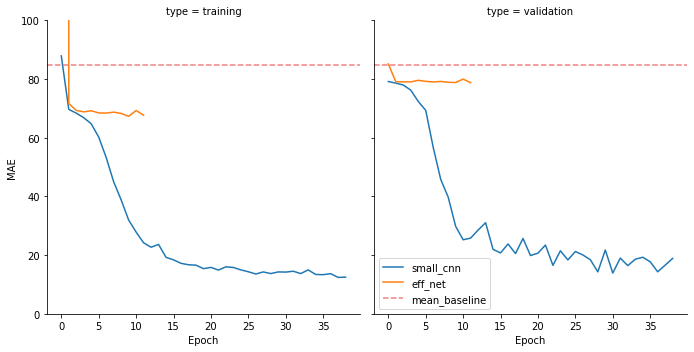

In [45]:
plot_results(small_cnn_history, eff_net_history, mean_baseline)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {}

참고:
- https://rosenfelder.ai/keras-regression-efficient-net/
- https://www.kaggle.com/code/nhm1440/image-metadata-with-keras-imagedatagenerator/notebook